## Seoul

In [96]:
import pandas as pd

# Get all data for Seoul (2024-2025) starting from May 2024 (skip the noise)
CITY_NAME = "seoul"
INT_YEARS = [2024, 2025]

DATE_FILTER = True
start_date = pd.Timestamp(f"{INT_YEARS[0]}-01-01")
end_date = pd.Timestamp(f"{INT_YEARS[-1]}-12-31")
start_date = pd.Timestamp(f"2024-05-01")
end_date = pd.Timestamp(f"2025-12-31")

timezone = "+09:00"
start_date_localized = start_date.tz_localize(timezone)
end_date_localized = end_date.tz_localize(timezone)

### Imports

In [97]:
# %load_ext autoreload
# %autoreload 2

import os
from pprint import pprint

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns

# from openaq_anomaly_prediction.config import Configuration as config
# from openaq_anomaly_prediction.utils.logging import logger, ProgressLogger
# from openaq_anomaly_prediction.load.openaq import client as openaq, AreaDownloader

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)

### Load dataset

In [98]:
# df_int_file = f"{CITY_NAME}_2025_measurements.int.parquet"
df_int_file = f"{CITY_NAME}_measurements_concatenated.parquet"
df_int_path = df_int_file
# df_int_path = os.path.join(config.DATA_CSV_PATH, df_int_file)
print(df_int_path)

seoul_measurements_concatenated.parquet


#### LOAD Parquet file

In [99]:
schema = pq.read_schema(df_int_path)
print(schema)
# print(schema.names)

location_id: int64
sensor_id: int64
name: string
value: double
parameter.id: int64
parameter.name: string
parameter.units: string
parameter.displayName: string
period.datetimeFrom.local: timestamp[ns, tz=+09:00]
period.datetimeTo.local: timestamp[ns, tz=+09:00]
period.datetimeFrom.utc: timestamp[ns, tz=UTC]
period.datetimeTo.utc: timestamp[ns, tz=UTC]
location.datetimeFirst.utc: timestamp[ns, tz=UTC]
location.datetimeLast.utc: timestamp[ns, tz=UTC]
coordinates.latitude: double
coordinates.longitude: double
location_name: string
isMobile: bool
isMonitor: bool
country.id: int64
country.code: string
country.name: string
owner.id: int64
owner.name: string
provider.id: int64
provider.name: string
coverage.expectedCount: int64
coverage.observedCount: int64
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 3874


In [100]:
metadata = pq.read_metadata(df_int_path)
print(metadata)
print()

if metadata.num_row_groups > 0:
    for i in range(metadata.num_row_groups):
        print(f"Rows in row group {i}: {metadata.row_group(i).num_rows}")

  created_by: parquet-cpp-arrow version 22.0.0
  num_columns: 28
  num_rows: 5763283
  num_row_groups: 6
  format_version: 2.6
  serialized_size: 33002

Rows in row group 0: 1048576
Rows in row group 1: 1048576
Rows in row group 2: 1048576
Rows in row group 3: 1048576
Rows in row group 4: 1048576
Rows in row group 5: 520403


In [101]:
df = pd.read_parquet(df_int_path)

#### FILTER the rows

In [102]:
# FILTER the raw parquet file to only include the desired rows
import pyarrow.dataset as ds


if not DATE_FILTER:
    print("NO DATE FILTER APPLIED")
    date_filter = None

else:
    print("FILTERING WITH DATE RANGE")
    # Match the exact type of the period.datetimeTo.local column
    target_type = pa.timestamp("ns", tz=timezone)
    # start_date_localized = start_date.tz_localize(timezone)
    # end_date_localized = end_date.tz_localize(timezone)

    # Convert pandas Timestamps to PyArrow Scalars with the target type
    start_scalar = pa.scalar(start_date_localized, type=target_type)
    end_scalar = pa.scalar(end_date_localized, type=target_type)

    date_filter = (ds.field("period.datetimeTo.local") >= start_scalar) & (
        ds.field("period.datetimeTo.local") <= end_scalar
    )

filtered_table = pq.read_table(
    df_int_path,
    filters=date_filter,
    # Optional: only load the columns you actually need
    columns=[
        "location_id",
        "sensor_id",
        "name",
        "value",
        "parameter.id",
        "parameter.name",
        "parameter.units",
        "parameter.displayName",
        "period.datetimeFrom.local",
        "period.datetimeTo.local",
        "period.datetimeFrom.utc",
        "period.datetimeTo.utc",
        # "location.datetimeFirst.utc",
        # "location.datetimeLast.utc",
        "coordinates.latitude",
        "coordinates.longitude",
        # "location_name",
        "isMobile",
        "isMonitor",
        # "country.id",
        # "country.code",
        # "country.name",
        # "owner.id",
        "owner.name",
        # "provider.id",
        "provider.name",
        # "coverage.expectedCount",
        # "coverage.observedCount",
    ],
)

# Convert the filtered result to a pandas DataFrame
filtered_df = filtered_table.to_pandas()
print(f"Shape: {filtered_df.shape}")
print(f"First: {filtered_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {filtered_df["period.datetimeTo.local"].max()} (UTC)")

FILTERING WITH DATE RANGE
Shape: (5406216, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


In [103]:
filtered_df.head(1)

,location_id,sensor_id,name,value,parameter.id,parameter.name,parameter.units,parameter.displayName,period.datetimeFrom.local,period.datetimeTo.local,period.datetimeFrom.utc,period.datetimeTo.utc,coordinates.latitude,coordinates.longitude,isMobile,isMonitor,owner.name,provider.name
0,2623440,8542022,pm10 µg/m³,23.0,1,pm10,µg/m³,PM10,2024-07-01 09:00:00+09:00,2024-07-01 10:00:00+09:00,2024-07-01 00:00:00+00:00,2024-07-01 01:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment


### Test Pollutant Coverage

In [104]:
# PREP: Identify top pollutants by number of unique locations measuring them

KEEP_TOP_N_POLLUTANTS = 6

title = "IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM"
print(f"{'='*len(title)}\n{title}\n")

print(f"Unique sensors: {filtered_df['sensor_id'].nunique()}")

print("\nNumber of unique locations measuring each parameter:")
unique_locations_groupby_name = filtered_df.groupby(["name"])["location_id"].nunique().sort_values(ascending=False)

print(unique_locations_groupby_name)  # count() or size()
top_pollutants_name = unique_locations_groupby_name[:KEEP_TOP_N_POLLUTANTS].index.tolist()

message = f"\nKEEPING the top {KEEP_TOP_N_POLLUTANTS} pollutants by number of unique locations:\n{top_pollutants_name}"
print(f"{message}\n{'_'*len(title)}")


IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM

Unique sensors: 444

Number of unique locations measuring each parameter:
name
pm25 µg/m³             75
co ppm                 73
no2 ppm                73
o3 ppm                 73
pm10 µg/m³             73
so2 ppm                73
pm1 µg/m³               1
relativehumidity %      1
temperature c           1
um003 particles/cm³     1
Name: location_id, dtype: int64

KEEPING the top 6 pollutants by number of unique locations:
['pm25 µg/m³', 'co ppm', 'no2 ppm', 'o3 ppm', 'pm10 µg/m³', 'so2 ppm']
_______________________________________________________________________


In [105]:
# TEST 1: for each location of the least common pollutant, see which pollutants are measured there

title = "POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT"
print(f"{'='*len(title)}\n{title}\n")
total_pollutants = len(top_pollutants_name)
least_common_pollutant = top_pollutants_name[-1]
least_common_pollutant_locations = filtered_df[filtered_df["name"] == least_common_pollutant]["location_id"].unique()

print(f"Checking every location ({len(least_common_pollutant_locations)}) measuring the least common pollutant ({least_common_pollutant}) to see if they also measure all top pollutants ({total_pollutants}):")
print(top_pollutants_name)
print()

full_locations = []
partial_locations = []
id_max_length = max(len(str(id)) for id in least_common_pollutant_locations)
for location in least_common_pollutant_locations:
    df_location = filtered_df[filtered_df["location_id"] == location]
    measured_parameters = df_location["name"].unique().tolist()
    overlap = set(measured_parameters).intersection(set(top_pollutants_name))
    if len(overlap) < total_pollutants:
        partial_locations.append(location)
        print(f"> Location {location:<{id_max_length}} : {len(overlap)}/{total_pollutants}")
    else:
        full_locations.append(location)

if len(partial_locations) == 0:
    print("=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS")

print()
message = f"Locations coverage for all of the top pollutants: {len(full_locations)/len(least_common_pollutant_locations):.2%} ({len(full_locations)}/{len(least_common_pollutant_locations)} locations)"
print(f"{message}\n{'_'*len(title)}")

POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT

Checking every location (73) measuring the least common pollutant (so2 ppm) to see if they also measure all top pollutants (6):
['pm25 µg/m³', 'co ppm', 'no2 ppm', 'o3 ppm', 'pm10 µg/m³', 'so2 ppm']

=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS

Locations coverage for all of the top pollutants: 100.00% (73/73 locations)
__________________________________________________________________________


In [110]:
# FILTER the dataframe to only include measurements from locations that measure all top pollutants

selected_locations = full_locations  # only location with full coverage (all top pollutants measured)
selected_df = filtered_df[(filtered_df["location_id"].isin(selected_locations)) & (filtered_df["name"].isin(top_pollutants_name))]

print(f"FILTERING ONLY THE LOCATIONS MEASURING ALL THE TOP {KEEP_TOP_N_POLLUTANTS} POLLUTANTS")
print(f"Shape: {selected_df.shape}")
print(f"First: {selected_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {selected_df["period.datetimeTo.local"].max()} (UTC)")

FILTERING ONLY THE LOCATIONS MEASURING ALL THE TOP 6 POLLUTANTS
Shape: (5368416, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


In [ ]:
# TEST 2.1: For each location, how much % of the total hours do they cover with measurements

THRESHOLD = 0.9

title = f"MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD"
print(f"{'=' * len(title)}\n{title}\n")

min_date = pd.Timestamp(selected_df["period.datetimeTo.local"].min())
max_date = pd.Timestamp(selected_df["period.datetimeTo.local"].max())

hourly_index = pd.date_range(
    start=min_date,
    end=max_date,
    # start=pd.Timestamp("2024-01-01").tz_localize("+05:30"),
    # end=pd.Timestamp("2025-12-31").tz_localize("+05:30"),
    # start=start_date_localized,
    # end=end_date_localized,
    freq='h'
)
number_of_hours = len(hourly_index)

print(f"From: {min_date}\nTo:   {max_date}")
print(f"Total Hours: {number_of_hours}\n")
POLLUTANTS = ['pm25 µg/m³', 'co ppm', 'no2 ppm', 'o3 ppm', 'pm10 µg/m³', 'so2 ppm']

KEPT_LOCATIONS = []
id_max_length = max(len(str(id)) for id in selected_locations)
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for location in selected_locations:
    df_location = selected_df[selected_df["location_id"] == location]

    location_string = f"[Location {location}]\n"

    # print(f"[Location {location:<{id_max_length}}]")

    min_coverage = None
    for pollutant in top_pollutants_name:

        df_location_pollutant = df_location[df_location["name"] == pollutant]
        pollutant_coverage = len(df_location_pollutant) / number_of_hours
        location_string += f"  - {pollutant:<{name_max_length}} : {pollutant_coverage:>7.2%} | {len(df_location_pollutant)}/{number_of_hours}\n"
        if min_coverage is None or pollutant_coverage < min_coverage:
            min_coverage = pollutant_coverage

    if min_coverage is not None and min_coverage > THRESHOLD:
        KEPT_LOCATIONS.append(int(location))

    print(location_string)

print()
message = f"{len(KEPT_LOCATIONS)}/{len(selected_locations)} locations with more than {THRESHOLD:.2%} hourly coverages for each pollutant:\n{KEPT_LOCATIONS}"
print(f"\n{'='*len(title)}\n\n{message}\n\n{'_'*len(title)}")


MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD

From: 2024-05-01 00:00:00+09:00
To:   2025-12-16 11:00:00+09:00
Total Hours: 14268

[Location 2622627]
  - pm25 µg/m³ :  99.47% | 14192/14268
  - co ppm     :  99.47% | 14192/14268
  - no2 ppm    :  99.47% | 14192/14268
  - o3 ppm     :  99.47% | 14192/14268
  - pm10 µg/m³ :  99.47% | 14192/14268
  - so2 ppm    :  99.47% | 14192/14268

[Location 2622932]
  - pm25 µg/m³ :  99.47% | 14192/14268
  - co ppm     :  99.47% | 14192/14268
  - no2 ppm    :  99.47% | 14192/14268
  - o3 ppm     :  99.47% | 14192/14268
  - pm10 µg/m³ :  99.47% | 14192/14268
  - so2 ppm    :  99.47% | 14192/14268

[Location 2623346]
  - pm25 µg/m³ :  99.47% | 14192/14268
  - co ppm     :  99.47% | 14192/14268
  - no2 ppm    :  99.47% | 14192/14268
  - o3 ppm     :  99.47% | 14192/14268
  - pm10 µg/m³ :  99.47% | 14192/14268
  - so2 ppm    :  99.47% | 14192/14268

[Location 2622714]
  - pm25 µg/m³ :  99.47% | 14192/14268
  - co ppm     :  99

In [114]:
final_df = selected_df[selected_df["location_id"].isin(KEPT_LOCATIONS)]

print(f"FINAL DATAFRAME: ALL LOCATIONS ({len(KEPT_LOCATIONS)}/{len(selected_locations)}) WITH +{THRESHOLD:.2%} COVERAGE FOR ALL POLLUTANTS")
print(f"Shape: {final_df.shape}")
print(f"First: {final_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {final_df["period.datetimeTo.local"].max()} (UTC)")

FINAL DATAFRAME: ALL LOCATIONS (58/73) WITH +90.00% COVERAGE FOR ALL POLLUTANTS
Shape: (4918548, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


NUMBER OF MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS (58)

----------------------------------------------------------------
[PM25 ΜG/M³]: 819758 measurements


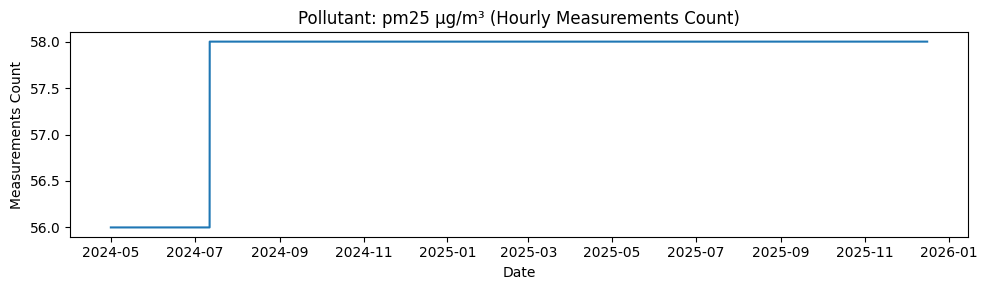

----------------------------------------------------------------
[CO PPM]: 819758 measurements


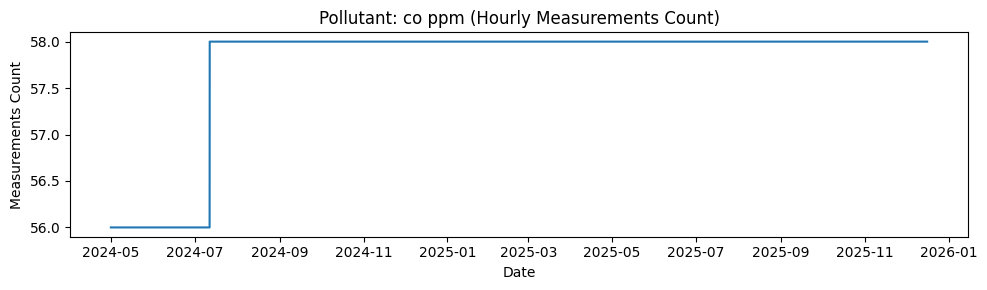

----------------------------------------------------------------
[NO2 PPM]: 819758 measurements


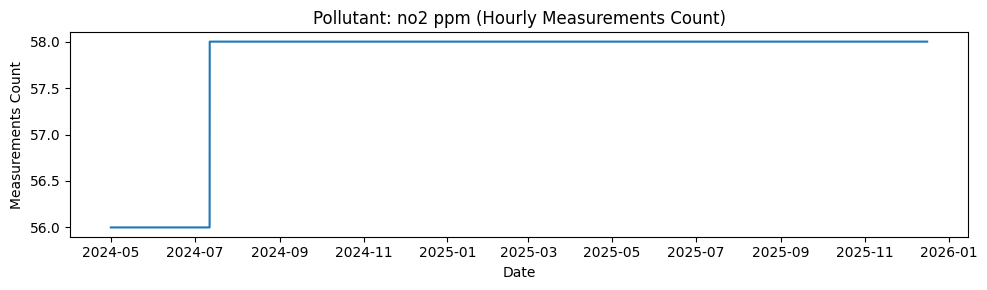

----------------------------------------------------------------
[O3 PPM]: 819758 measurements


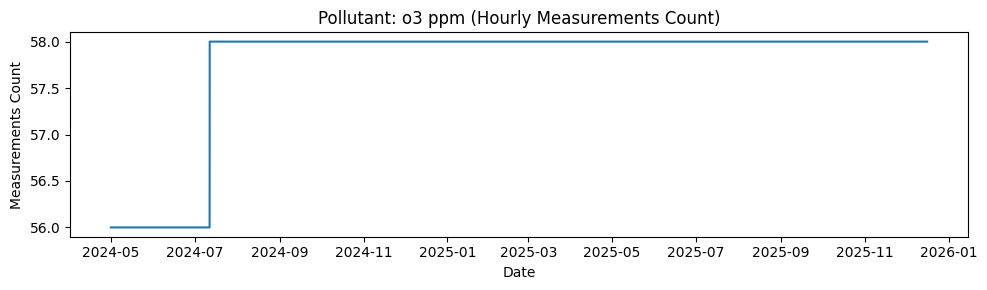

----------------------------------------------------------------
[PM10 ΜG/M³]: 819758 measurements


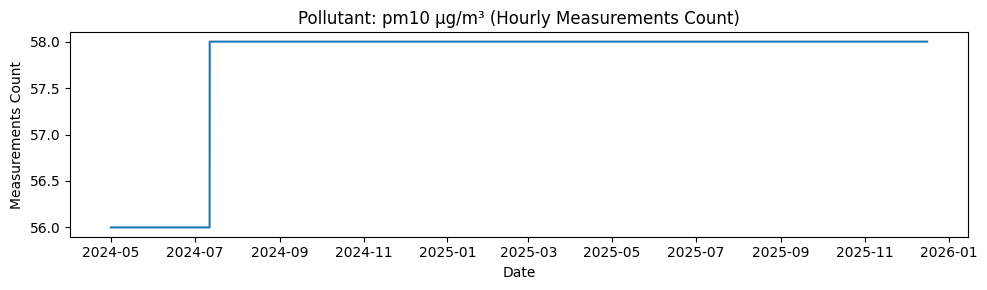

----------------------------------------------------------------
[SO2 PPM]: 819758 measurements


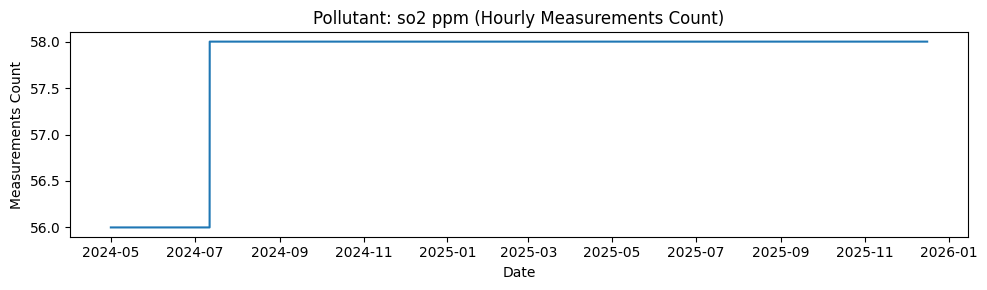

In [115]:
# TEST 2.2: for each pollutant, how many measurements (rows) do we have for the selected locations
# We already selected locations measuring all top pollutants with large coverage

# Just to have an idea of how many hours have low measurement counts
LOW_MEASUREMENT_COUNT_THRESHOLD = 40

title = f"NUMBER OF MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS ({final_df['location_id'].nunique()})"
print(f"{'=' * len(title)}\n{title}\n")

unique_hours = final_df["period.datetimeTo.local"].nunique()
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for i, pollutant in enumerate(top_pollutants_name):
    df_pollutant = final_df[final_df["name"] == pollutant]
    df_pollutant_by_datetime = df_pollutant.groupby("period.datetimeTo.local")["value"].count().reset_index()

    MASK_DATE_FILTER = pd.Series(True, index=df_pollutant_by_datetime.index)  # default: no filter
    # MASK_DATE_FILTER = (df_pollutant_by_datetime["period.datetimeTo.local"] >= "2025-03-01") & (df_pollutant_by_datetime["period.datetimeTo.local"] < "2025-05-01")

    print(f"{'-' * len(title)}\n[{pollutant.upper()}]: {df_pollutant.shape[0]} measurements")
    measurements_low_count = df_pollutant_by_datetime[df_pollutant_by_datetime["value"] < LOW_MEASUREMENT_COUNT_THRESHOLD].shape[0]
    # print(f"> Number of hours with low measurement counts (<{LOW_MEASUREMENT_COUNT_THRESHOLD}): {measurements_low_count/unique_hours:.2%} ({measurements_low_count}/{unique_hours})")


    fig, ax =plt.subplots(1, 1, figsize=(10, 3))
    sns.lineplot(data=df_pollutant_by_datetime[MASK_DATE_FILTER], x="period.datetimeTo.local", y="value", ax=ax)
    ax.set_title(f"Pollutant: {pollutant} (Hourly Measurements Count)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Measurements Count")
    plt.tight_layout()
    plt.show()

# message = f"Locations coverage for all of the top pollutants: {full_locations_count/len(least_common_pollutant_locations):.2%} ({full_locations_count}/{len(least_common_pollutant_locations)} locations)"
# print(f"{message}\n{'_'*len(title)}")


### HEAD

In [119]:
final_df.columns

Index(['location_id', 'sensor_id', 'name', 'value', 'parameter.id', 'parameter.name', 'parameter.units', 'parameter.displayName', 'period.datetimeFrom.local', 'period.datetimeTo.local', 'period.datetimeFrom.utc', 'period.datetimeTo.utc', 'coordinates.latitude', 'coordinates.longitude', 'isMobile', 'isMonitor', 'owner.name', 'provider.name'], dtype='object')

### Extreme values

NUMBER OF EXTREME MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS (58)

------------------------------------------------------------------------
[PM25 ΜG/M³]: 40114 measurements


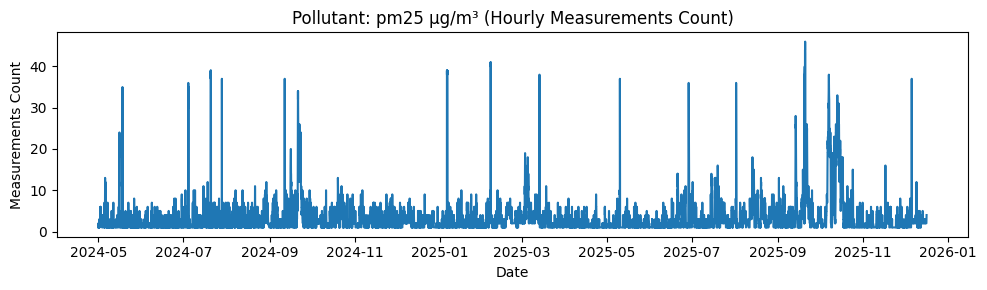

------------------------------------------------------------------------
[CO PPM]: 16797 measurements


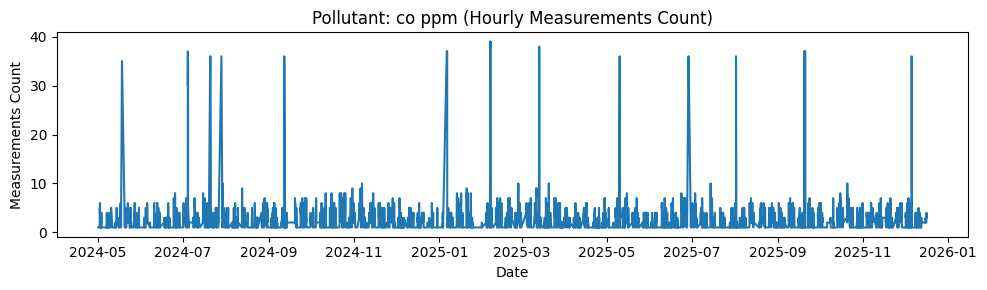

------------------------------------------------------------------------
[NO2 PPM]: 16768 measurements


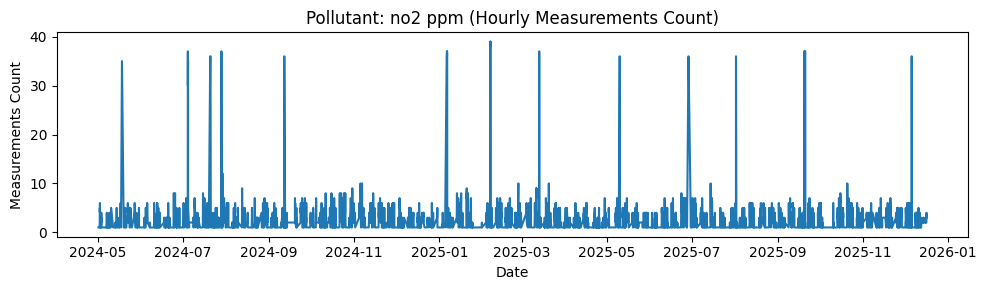

------------------------------------------------------------------------
[O3 PPM]: 19743 measurements


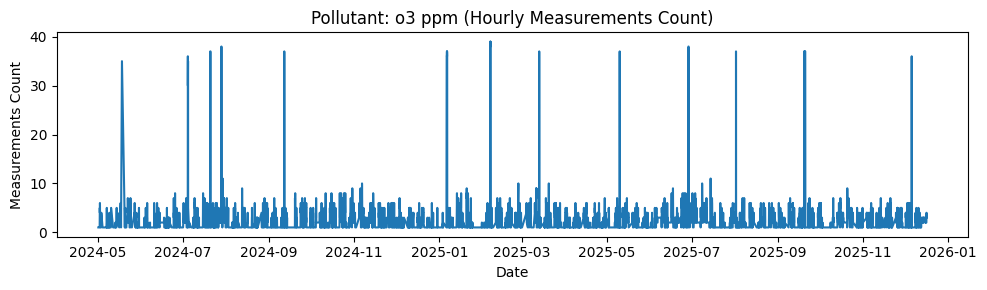

------------------------------------------------------------------------
[PM10 ΜG/M³]: 29681 measurements


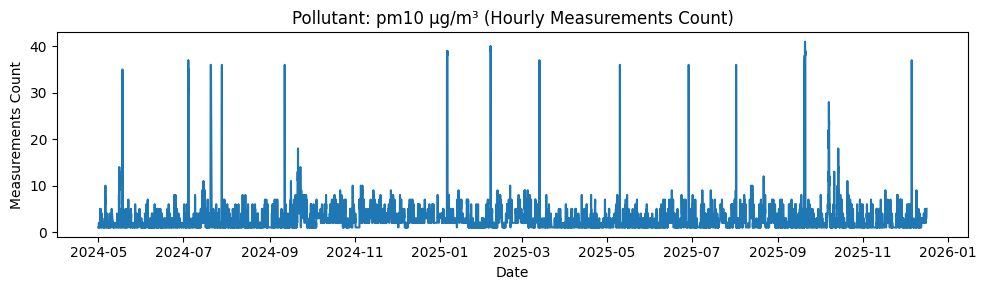

------------------------------------------------------------------------
[SO2 PPM]: 19632 measurements


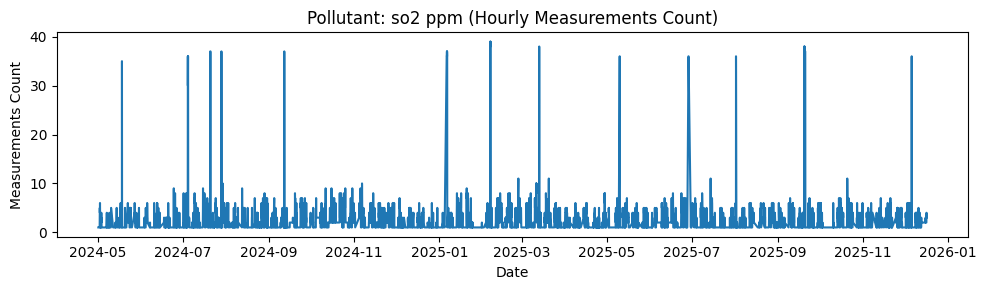

In [117]:
# TEST 3: for each pollutant, how many EXTREME measurements (rows) do we have for the selected locations
# We already selected locations measuring all top pollutants with large coverage

# Just to have an idea of how many hours have low measurement counts
EXTREME_THRESHOLD = 9000

title = f"NUMBER OF EXTREME MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS ({final_df['location_id'].nunique()})"
print(f"{'=' * len(title)}\n{title}\n")

unique_hours = final_df["period.datetimeTo.local"].nunique()
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for i, pollutant in enumerate(top_pollutants_name):
    df_pollutant = final_df[(final_df["name"] == pollutant) & (final_df["value"] >= EXTREME_THRESHOLD)]
    df_pollutant_by_datetime = df_pollutant.groupby("period.datetimeTo.local")["value"].count().reset_index()

    MASK_DATE_FILTER = pd.Series(True, index=df_pollutant_by_datetime.index)  # default: no filter
    # MASK_DATE_FILTER = (df_pollutant_by_datetime["period.datetimeTo.local"] >= "2025-03-01") & (df_pollutant_by_datetime["period.datetimeTo.local"] < "2025-05-01")

    print(f"{'-' * len(title)}\n[{pollutant.upper()}]: {df_pollutant.shape[0]} measurements")
    measurements_low_count = df_pollutant_by_datetime[df_pollutant_by_datetime["value"] < LOW_MEASUREMENT_COUNT_THRESHOLD].shape[0]
    # print(f"> Number of hours with low measurement counts (<{LOW_MEASUREMENT_COUNT_THRESHOLD}): {measurements_low_count/unique_hours:.2%} ({measurements_low_count}/{unique_hours})")


    fig, ax =plt.subplots(1, 1, figsize=(10, 3))
    sns.lineplot(data=df_pollutant_by_datetime[MASK_DATE_FILTER], x="period.datetimeTo.local", y="value", ax=ax)
    ax.set_title(f"Pollutant: {pollutant} (Hourly Measurements Count)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Measurements Count")
    plt.tight_layout()
    plt.show()

# message = f"Locations coverage for all of the top pollutants: {full_locations_count/len(least_common_pollutant_locations):.2%} ({full_locations_count}/{len(least_common_pollutant_locations)} locations)"
# print(f"{message}\n{'_'*len(title)}")


### Final EDA checks

In [56]:
final_df.head(1)

,location_id,sensor_id,name,value,parameter.id,parameter.name,parameter.units,parameter.displayName,period.datetimeFrom.local,period.datetimeTo.local,period.datetimeFrom.utc,period.datetimeTo.utc,coordinates.latitude,coordinates.longitude,isMobile,isMonitor,owner.name,provider.name
0,2623440,8542022,pm10 µg/m³,23.0,1,pm10,µg/m³,PM10,2024-07-01 09:00:00+09:00,2024-07-01 10:00:00+09:00,2024-07-01 00:00:00+00:00,2024-07-01 01:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment


In [25]:
print(f"{'='*72}\nFINAL DATAFRAME: ALL LOCATIONS ({len(KEPT_LOCATIONS)}/{len(selected_locations)}) WITH +{THRESHOLD:.2%} COVERAGE FOR ALL POLLUTANTS")
print(f"Shape: {final_df.shape}")
print(f"First: {final_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {final_df["period.datetimeTo.local"].max()} (UTC)")
print()

final_unique_locations = final_df["location_id"].unique()
print(f"{'-'*72}\nLOCATIONS: {len(final_unique_locations)}\n{final_unique_locations}")
print("\n")


print(f"\n{'-'*72}\nPOLLUTANTS:")
print(final_df["name"].value_counts().reset_index())
print("\n")

print(f"\n{'-'*72}\nVALUES (describe):")
display(final_df.groupby("name")["value"].describe())
print("\n")

print(f"OWNERS (value_counts):")
print(final_df["owner.name"].value_counts())
print(f"\nPROVIDERS (value_counts):")
print(final_df["provider.name"].value_counts())
print("\n")

print(f"isMobile (value_counts):")
print(final_df["isMobile"].value_counts())
print(f"\nisMonitor (value_counts):")
print(final_df["isMonitor"].value_counts())
print("\n")


FINAL DATAFRAME: ALL LOCATIONS (58/73) WITH +90.00% COVERAGE FOR ALL POLLUTANTS
Shape: (4918548, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)

------------------------------------------------------------------------
LOCATIONS: 58
[2623440 2622675 2622950 2622916 2623214 2623052 2622627 2622608 2623586
 2623504 2622932 2623346 2623422 2622714 2623394 2622851 2622782 2622858
 2623344 2622689 2623321 2623557 2623811 2623080 2623112 2623681 2623198
 2622918 2623154 2622727 2622796 2622827 2623643 2623424 2623444 2623048
 2623069 2623563 2622995 2623004 2623465 2623259 2623718 2623345 2622724
 2622907 2623532 2622837 2623538 2622586 2622825 2623430 2623116 2623078
 2623442 2623194 2622807 2623679]



------------------------------------------------------------------------
POLLUTANTS:
         name   count
0  pm10 µg/m³  819758
1      co ppm  819758
2      o3 ppm  819758
3  pm25 µg/m³  819758
4     so2 ppm  819758
5     no2 ppm  819758



----------------

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
co ppm,819758.0,205.300103,1416.641751,0.0,0.3000,0.3800,0.5000,10000.0
no2 ppm,819758.0,204.566148,1415.498799,0.0,0.0093,0.0153,0.0255,10000.0
o3 ppm,819758.0,240.869807,1533.094355,0.0,0.0166,0.0292,0.0433,10000.0
pm10 µg/m³,819758.0,391.720335,1862.409862,0.0,18.0000,27.0000,41.0000,10000.0
pm25 µg/m³,819758.0,505.134495,2153.755010,0.0,8.0000,14.0000,24.0000,10000.0
so2 ppm,819758.0,239.487839,1528.888989,0.0,0.0021,0.0025,0.0030,10000.0




OWNERS (value_counts):
owner.name
Unknown Governmental Organization    4918548
Name: count, dtype: int64

PROVIDERS (value_counts):
provider.name
Korea Air Ministry of Environment    4918548
Name: count, dtype: int64


isMobile (value_counts):
isMobile
False    4918548
Name: count, dtype: int64

isMonitor (value_counts):
isMonitor
True    4918548
Name: count, dtype: int64




### DEEP DIVE POLLUTION SPIKE: pm25 µg/m³

In [222]:
EXTREME_THRESHOLD = 5000

In [195]:
FINAL_POLLUTANTS = ["pm25 µg/m³"]
# FINAL_POLLUTANTS = top_pollutants_name

# Date filter (mask)
PM25_PEAKS = [
    # Peak 1 hour (PM25: 16 x 10k)
    (pd.Timestamp("2025-11-16T21:30:00").tz_localize(timezone), pd.Timestamp("2025-11-16T22:30:00").tz_localize(timezone)),

    # Peak over 5 hours gradually (PM25: 8 > 41 > 40 > 41 > 7 off)
    (pd.Timestamp("2025-02-06T13:30:00").tz_localize(timezone), pd.Timestamp("2025-02-06T14:30:00").tz_localize(timezone)),
    (pd.Timestamp("2025-02-06T14:30:00").tz_localize(timezone), pd.Timestamp("2025-02-06T15:30:00").tz_localize(timezone)),
    (pd.Timestamp("2025-02-06T15:30:00").tz_localize(timezone), pd.Timestamp("2025-02-06T16:30:00").tz_localize(timezone)),
]

peaks_locations = []
for peak in PM25_PEAKS:
    peak_mask = (final_df["period.datetimeTo.local"] >= peak[0]) & (final_df["period.datetimeTo.local"] <= peak[1])
    df_pollutant = final_df[(final_df["value"] > 2000) & (final_df["name"] == FINAL_POLLUTANTS[0]) & peak_mask][["location_id", "name", "value", "period.datetimeTo.local"]]
    print(f"Shape: {df_pollutant.shape} | Unique locations: {df_pollutant["location_id"].nunique()}")
    # display(df_pollutant.head(100))

    peaks_locations.append(df_pollutant["location_id"].unique())

Shape: (16, 4) | Unique locations: 16
Shape: (41, 4) | Unique locations: 41
Shape: (40, 4) | Unique locations: 40
Shape: (41, 4) | Unique locations: 41


Extreme measurements (>5000) : (8, 4)
Unique locations             :  8
[2623069, 2623112, 2622851, 2623345, 2622827, 2622858, 2623586, 2623048]

Extreme measurements (>5000) : (41, 4)
Unique locations             :  41
[2623532, 2622689, 2623586, 2622586, 2622782, 2623557, 2623069, 2622916, 2622796, 2622727, 2623504, 2623344, 2623811, 2623154, 2622950, 2623052, 2623465, 2623679, 2623004, 2623440, 2623194, 2622858, 2623346, 2623394, 2623345, 2622827, 2623112, 2623116, 2623718, 2623198, 2623259, 2622608, 2623080, 2623424, 2622837, 2623563, 2622675, 2623430, 2623048, 2623321, 2622907]

Extreme measurements (>5000) : (40, 4)
Unique locations             :  40
[2623345, 2623004, 2622858, 2623346, 2623586, 2623069, 2622782, 2623112, 2622675, 2623048, 2623198, 2623465, 2622950, 2623194, 2622796, 2623394, 2623116, 2622827, 2623718, 2622608, 2623424, 2623080, 2623563, 2623321, 2623430, 2622907, 2622837, 2623259, 2623532, 2623811, 2622689, 2623679, 2623052, 2623154, 2622727, 2623440, 2623344, 2

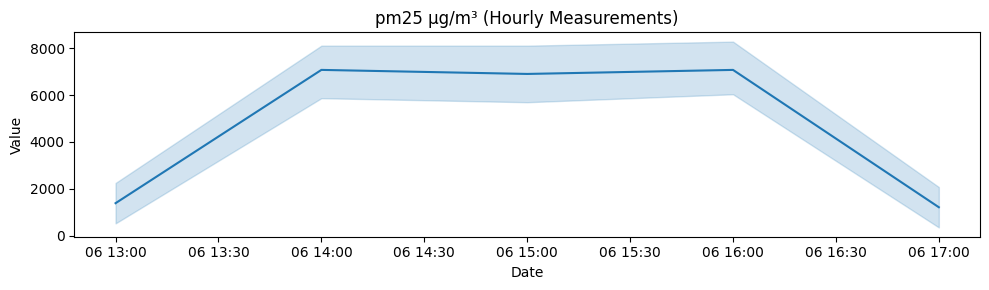

In [232]:
import matplotlib.dates as mdates

FINAL_DATE_FILTER = True
FINAL_POLLUTANTS = ["pm25 µg/m³"]
# FINAL_POLLUTANTS = top_pollutants_name

# Date filter (mask)

# Peak 1 hour (PM25: 16 x 10k)
# final_start_date = pd.Timestamp("2025-11-16T20:30:00").tz_localize(timezone)
# final_end_date = pd.Timestamp("2025-11-16T23:30:00").tz_localize(timezone)

# Peak over 3 hours (PM25: 36 x 10k): [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]
# final_start_date = pd.Timestamp("2025-06-28T14:30:00").tz_localize(timezone)
# final_end_date = pd.Timestamp("2025-06-28T19:30:00").tz_localize(timezone)

# Peak over 5 hours gradually (PM25: 8 > 41 > 40 > 41 > 7 off)
final_start_date = pd.Timestamp("2025-02-06T12:30:00").tz_localize(timezone)
final_end_date = pd.Timestamp("2025-02-06T17:30:00").tz_localize(timezone)

if FINAL_DATE_FILTER:
    date_filter = (final_df["period.datetimeTo.local"] >= final_start_date) & (final_df["period.datetimeTo.local"] <= final_end_date)
else:
    date_filter = pd.Series(True, index=final_df["period.datetimeTo.local"].index)  # default: no filter

# Make a groupby to make a time series: just change the aggregation method: mean, median, count...
final_value_groupby_name = final_df[date_filter].groupby(['period.datetimeTo.local', 'name'])['value'].mean().reset_index()

for pollutant in FINAL_POLLUTANTS:
    # GROUPBY (MEAN)
    # df_pollutant = final_value_groupby_name[final_value_groupby_name["name"] == pollutant]

    # Used to plot, we need both the normal and extreme values
    df_pollutant = final_df[(final_df["name"] == pollutant) & date_filter][["location_id", "name", "value", "period.datetimeTo.local"]]

    # Used to make stats about extreme values
    df_extreme_values = df_pollutant[df_pollutant["value"] > EXTREME_THRESHOLD].sort_values(by="period.datetimeTo.local")

    for hour in df_extreme_values["period.datetimeTo.local"].unique():
        df_hour = df_extreme_values[df_extreme_values["period.datetimeTo.local"] == hour]

        hour_unique_locations = df_hour["location_id"].unique()
        print(f"Extreme measurements (>{EXTREME_THRESHOLD}) : {df_hour.shape}")
        print(f"Unique locations             :  {len(hour_unique_locations)}\n{hour_unique_locations.tolist()}\n")

    # display(df_pollutant.head(100))


    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(data=df_pollutant, x="period.datetimeTo.local", y="value", ax=ax)

    # ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # ax.grid(visible=True, which='major', axis='x', linestyle='--', alpha=0.5, zorder=1)

    ax.set_title(f"{pollutant} (Hourly Measurements)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [242]:
a = [2623069, 2623112, 2622851, 2623345, 2622827, 2622858, 2623586, 2623048]
b = [2623532, 2622689, 2623586, 2622586, 2622782, 2623557, 2623069, 2622916, 2622796, 2622727, 2623504, 2623344, 2623811, 2623154, 2622950, 2623052, 2623465, 2623679, 2623004, 2623440, 2623194, 2622858, 2623346, 2623394, 2623345, 2622827, 2623112, 2623116, 2623718, 2623198, 2623259, 2622608, 2623080, 2623424, 2622837, 2623563, 2622675, 2623430, 2623048, 2623321, 2622907]
c = [2623345, 2623004, 2622858, 2623346, 2623586, 2623069, 2622782, 2623112, 2622675, 2623048, 2623198, 2623465, 2622950, 2623194, 2622796, 2623394, 2623116, 2622827, 2623718, 2622608, 2623424, 2623080, 2623563, 2623321, 2623430, 2622907, 2622837, 2623259, 2623532, 2623811, 2622689, 2623679, 2623052, 2623154, 2622727, 2623440, 2623344, 2623557, 2622916, 2622586]
d = [2623321, 2622950, 2622608, 2622858, 2622782, 2622916, 2623116, 2623194, 2623811, 2623112, 2623532, 2623465, 2623345, 2622796, 2623394, 2622827, 2623718, 2623424, 2623080, 2623563, 2623430, 2622907, 2623259, 2622727, 2622689, 2622586, 2623557, 2623440, 2623344, 2623052, 2623679, 2623198, 2622837, 2623004, 2622714, 2623069, 2623048, 2623154, 2623586, 2622675, 2623346]
e = [2623345, 2623069, 2622825, 2622858, 2623679, 2622827, 2622714]

first = e
second = d
intersection = [n for n in first if n in second]
print(f"% of [a] in [b]: {len(intersection)/len(first):.2%}")


% of [a] in [b]: 85.71%


In [220]:
a = [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]

b = [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]

c = [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]


print(sorted(a) == sorted(b))
print(sorted(a) == sorted(c))
print(sorted(b) == sorted(c))


True
True
True


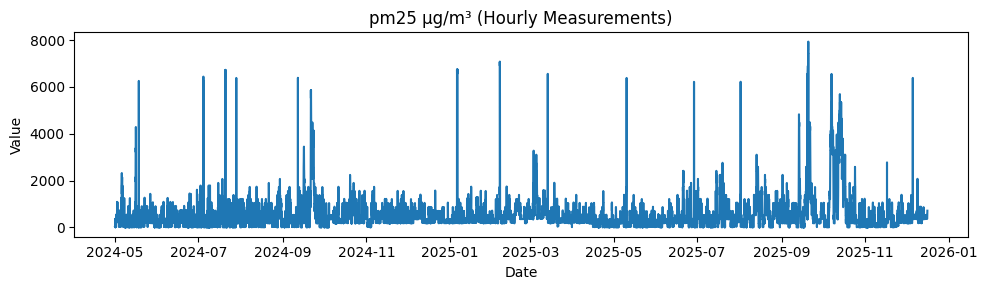

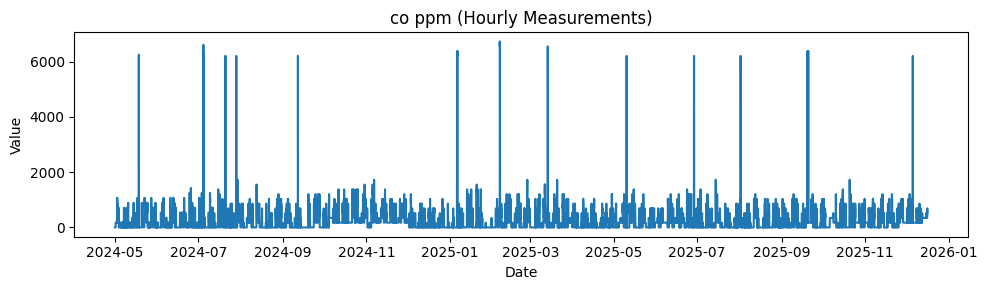

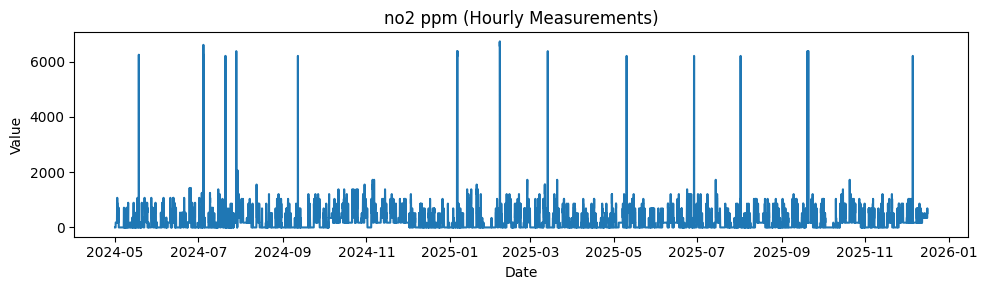

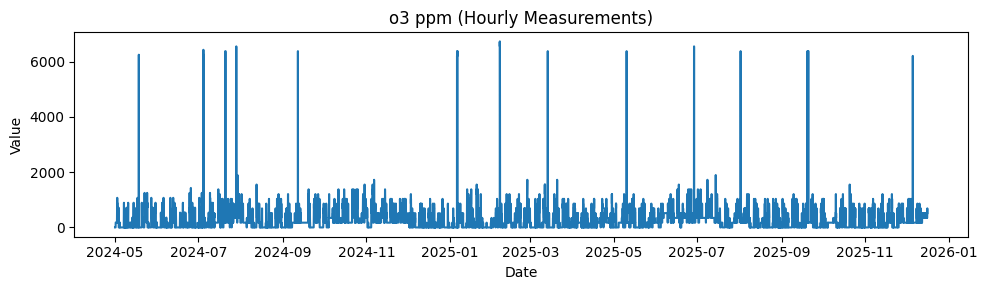

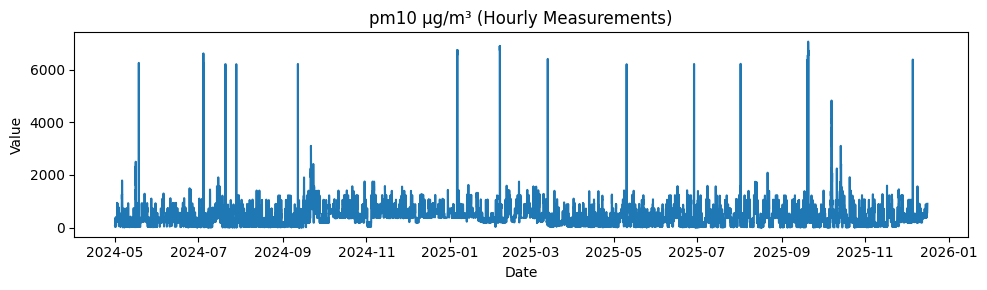

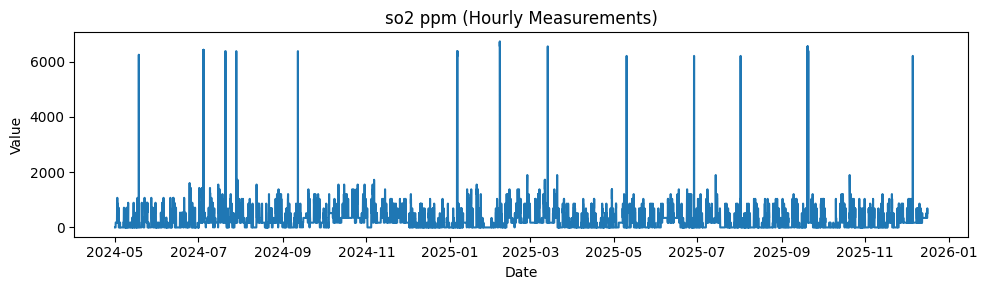

In [179]:
import matplotlib.dates as mdates

FINAL_SHOW_HOURS = False
FINAL_DATE_FILTER = False
# FINAL_POLLUTANTS = ["pm25 µg/m³"]
FINAL_POLLUTANTS = top_pollutants_name

# myFmt = mdates.DateFormatter("%d/%m %H:%M")
# myFmt = mdates.DateFormatter("%d/%m %Hh")

# Date filter (mask)
final_start_date = pd.Timestamp("2025-05-05T12:00:00").tz_localize(timezone)
final_end_date = pd.Timestamp("2025-05-16T00:00:00").tz_localize(timezone)

if FINAL_DATE_FILTER:
    date_filter = (final_df["period.datetimeTo.local"] >= final_start_date) & (final_df["period.datetimeTo.local"] <= final_end_date)
else:
    date_filter = pd.Series(True, index=final_df["period.datetimeTo.local"].index)  # default: no filter

# Make a groupby to make a time series: just change the aggregation method: mean, median, count...
final_value_groupby_name = final_df[date_filter].groupby(['period.datetimeTo.local', 'name'])['value'].mean().reset_index()

for pollutant in FINAL_POLLUTANTS:
    df_pollutant = final_value_groupby_name[final_value_groupby_name["name"] == pollutant]

    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(data=df_pollutant, x="period.datetimeTo.local", y="value", ax=ax)
    ax.set_title(f"{pollutant} (Hourly Measurements)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")

    if FINAL_SHOW_HOURS:
        # ax.xaxis.set_major_locator(mdates.HourLocator())
        # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m-%H:%M"))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [53]:
# Anomaly: 2025-12-05T19:00:00+09:00
final_df[final_df["period.datetimeTo.local"] == '2025-12-05T19:00:00+09:00']["value"].describe()

,value
count,348.000000
mean,6266.380669
std,4841.854927
min,0.000900
25%,0.860000
50%,10000.000000
75%,10000.000000
max,10000.000000


In [67]:
# Filter to only show extreme values

EXTREME_VALUE = 5000
FINAL_DATE_FILTER = True
# FINAL_POLLUTANTS = ["pm25 µg/m³"]
FINAL_POLLUTANTS = top_pollutants_name

# Date filter (mask)
final_start_date = pd.Timestamp("2024-01-01T12:00:00").tz_localize(timezone)
final_end_date = pd.Timestamp("2025-12-31").tz_localize(timezone)

if FINAL_DATE_FILTER:
    date_filter = (final_df["period.datetimeTo.local"] >= final_start_date) & (final_df["period.datetimeTo.local"] <= final_end_date)
else:
    date_filter = pd.Series(True, index=final_df["period.datetimeTo.local"].index)  # default: no filter

final_df_extreme_values = final_df[date_filter & (final_df["value"] > EXTREME_VALUE)]


display(final_df_extreme_values.head())

print(f"Number of extreme values (>{EXTREME_VALUE}): {len(final_df_extreme_values)}")
print(f"Number of locations with extreme values (>{EXTREME_VALUE}): {final_df_extreme_values["location_id"].nunique()}")

# print(f"Number of extreme values (>{EXTREME_VALUE}): {len(final_df_extreme_values)}")

,location_id,sensor_id,name,value,parameter.id,parameter.name,parameter.units,parameter.displayName,period.datetimeFrom.local,period.datetimeTo.local,period.datetimeFrom.utc,period.datetimeTo.utc,coordinates.latitude,coordinates.longitude,isMobile,isMonitor,owner.name,provider.name
76,2623440,8542022,pm10 µg/m³,10000.0,1,pm10,µg/m³,PM10,2024-07-04 15:00:00+09:00,2024-07-04 16:00:00+09:00,2024-07-04 06:00:00+00:00,2024-07-04 07:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment
78,2623440,8542022,pm10 µg/m³,10000.0,1,pm10,µg/m³,PM10,2024-07-04 17:00:00+09:00,2024-07-04 18:00:00+09:00,2024-07-04 08:00:00+00:00,2024-07-04 09:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment
79,2623440,8542022,pm10 µg/m³,10000.0,1,pm10,µg/m³,PM10,2024-07-04 18:00:00+09:00,2024-07-04 19:00:00+09:00,2024-07-04 09:00:00+00:00,2024-07-04 10:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment
80,2623440,8542022,pm10 µg/m³,10000.0,1,pm10,µg/m³,PM10,2024-07-04 19:00:00+09:00,2024-07-04 20:00:00+09:00,2024-07-04 10:00:00+00:00,2024-07-04 11:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment
211,2623440,8542022,pm10 µg/m³,10000.0,1,pm10,µg/m³,PM10,2024-07-10 11:00:00+09:00,2024-07-10 12:00:00+09:00,2024-07-10 02:00:00+00:00,2024-07-10 03:00:00+00:00,37.593749,126.949534,False,True,Unknown Governmental Organization,Korea Air Ministry of Environment


Number of extreme values (>5000): 142735
Number of locations with extreme values (>5000): 58


In [72]:
final_df = selected_df[selected_df["location_id"].isin(KEPT_LOCATIONS)]

print(f"FINAL DATAFRAME: ALL LOCATIONS ({len(KEPT_LOCATIONS)}/{len(selected_locations)}) WITH +{THRESHOLD:.2%} COVERAGE FOR ALL POLLUTANTS")
print(f"Shape: {final_df.shape}")
print(f"First: {final_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {final_df["period.datetimeTo.local"].max()} (UTC)")

FINAL DATAFRAME: ALL LOCATIONS (58/73) WITH +90.00% COVERAGE FOR ALL POLLUTANTS
Shape: (4918548, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


In [76]:
extreme_df = final_df[final_df["value"] > 3000]

print(f"EXTREME DATAFRAME: VALUE > {EXTREME_VALUE}")
print(f"Shape: {extreme_df.shape}")
print(f"First: {extreme_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {extreme_df["period.datetimeTo.local"].max()} (UTC)")

EXTREME DATAFRAME: VALUE > 5000
Shape: (142735, 18)
First: 2024-05-01 02:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


In [123]:
for pollutant in top_pollutants_name:
    df_pollutant = extreme_df[extreme_df["name"] == pollutant]

    print(f"{pollutant.upper()}: VALUE > {EXTREME_VALUE}")
    print(f"Shape: {df_pollutant.shape}")
    print(f"First: {df_pollutant["period.datetimeTo.local"].min()} (UTC)")
    print(f"Last : {df_pollutant["period.datetimeTo.local"].max()} (UTC)")
    print(f"Min value: {df_pollutant["value"].min()}")
    print(f"Max value: {df_pollutant["value"].max()}")
    display(df_pollutant["location_id"].nunique())
    print()


# & ("period.datetimeTo.local" == extreme_df[extreme_df["name"] == pollutant]["period.datetimeTo.local"].max())

display()



PM25 ΜG/M³: VALUE > 5000
Shape: (40114, 18)
First: 2024-05-01 02:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


CO PPM: VALUE > 5000
Shape: (16797, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


NO2 PPM: VALUE > 5000
Shape: (16768, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


O3 PPM: VALUE > 5000
Shape: (19743, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


PM10 ΜG/M³: VALUE > 5000
Shape: (29681, 18)
First: 2024-05-01 02:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


SO2 PPM: VALUE > 5000
Shape: (19632, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58

In [93]:
max_df = final_df[final_df["value"] == 10000]
max_df.shape

(142735, 18)

In [95]:
max_df["location_id"].nunique()

58

In [68]:
# final_df_extreme_values.set_index("period.datetimeTo.local").sort_index()

extreme_timeserie = final_df[final_df["value"] > EXTREME_VALUE]["period.datetimeTo.local"].value_counts().sort_index()
extreme_timeserie[:10]
# extreme_timeserie = final_df_extreme_values["period.datetimeTo.local"].value_counts().sort_index()

# final_df_extreme_values["value"].describe()

# extreme_groupby_pollutant = final_df_extreme_values.groupby(["period.datetimeTo.local", "name"])["value"].count()
# display(extreme_groupby_pollutant.describe())

# for pollutant in FINAL_POLLUTANTS:
#     df_pollutant = final_df_extreme_values[final_df_extreme_values["name"] == pollutant]

#     fig, ax = plt.subplots(figsize=(10, 3))
#     sns.scatterplot(data=df_pollutant, x="period.datetimeTo.local", y="value")
#     plt.tight_layout()
#     plt.show()
#     plt.close(fig)

,count
period.datetimeTo.local,
2024-05-01 02:00:00+09:00,2
2024-05-01 03:00:00+09:00,3
2024-05-01 05:00:00+09:00,2
2024-05-01 07:00:00+09:00,1
2024-05-01 10:00:00+09:00,1
2024-05-01 11:00:00+09:00,7
2024-05-01 12:00:00+09:00,8
2024-05-01 13:00:00+09:00,7
2024-05-01 14:00:00+09:00,7


#### Archives

In [ ]:
# OVERLAP of each pollutant with each others

# TODO: Test ONLY the unique locations of the least common pollutant
# but test

# Either jsut this one:
# least_common_pollutant_locations = filtered_df[filtered_df["name"] == least_common_pollutant]["location_id"].unique()
# # or the tested_pollutant_locations
# print(len(least_common_pollutant_locations))

name_max_length = max(len(name) for name in top_pollutants_name)
for pollutant in top_pollutants_name:
    tested_pollutant = pollutant
    tested_pollutant_locations = filtered_df[filtered_df["name"] == tested_pollutant]["location_id"].unique()
    other_pollutants = [p for p in top_pollutants_name if p != tested_pollutant]


    # print(f"Tested pollutant: {tested_pollutant}")
    print(f"[TESTING: {tested_pollutant.upper()} LOCATIONS ({len(tested_pollutant_locations)}) : Testing overlap of each pollutant with the tested pollutant:")
    print(f"  Other pollutants: {other_pollutants}")
    for other in other_pollutants:
        pollutant_locations = filtered_df[filtered_df["name"] == other]["location_id"].unique()

        common_locations = set(tested_pollutant_locations).intersection(set(pollutant_locations))
        print(f"  {other:<{name_max_length}} : {len(common_locations)/len(tested_pollutant_locations):>7.2%} ({len(common_locations)}/{len(tested_pollutant_locations)})")
    print()

In [ ]:
# Test if one of the locations measuring um003 actually measures all metrics

location_to_test = unique_locations_tested[4]
df_location = filtered_df[filtered_df["location_id"] == location_to_test]
measured_parameters = df_location["name"].unique().tolist()
print(f"Location ID {location_to_test} measures the following parameters: {measured_parameters}")

In [ ]:
pollutants_dict = {}

# Get the unique locations list for each pollutant
for pollutant in top_pollutants_name:
    unique_locations = filtered_df[filtered_df["name"] == pollutant]["location_id"].unique()
    pollutants_dict[pollutant] = unique_locations
    # pollutants_dict[pollutant] = len(unique_locations)
    # print(f"{pollutant}: {len(unique_locations)} unique locations")

# print()
# print(pollutants_dict)

# Compare each pollutant's unique locations with pm25 unique locations to find overlaps
for pollutant in top_pollutants_name:
    if pollutant == "pm25 µg/m³":
        continue  # Skip comparison with itself
    unique_locations = pollutants_dict[pollutant]
    overlap = set(unique_locations_pm25).intersection(set(unique_locations))
    print(f"Overlap between pm25 µg/m³ and {pollutant}: {len(overlap)/len(unique_locations):.2%} ({len(overlap)}/{len(unique_locations)} locations)")

In [ ]:
result_df = (
    filtered_df.groupby("name")
    .agg(station_count=('sensor_id', 'count')) # Use a tuple (new_col_name, aggregation_func)
    .sort_values(by='station_count', ascending=False)
)
display(result_df)

In [ ]:
filtered_df["name"].value_counts()

In [ ]:
groupby = filtered_df.groupby(["location_id", "name"]).size().sort_values(ascending=False)
pprint(groupby)